
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [122]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from plotnine import *
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [123]:
heart_data = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [124]:
# Select features and target
X = heart_data.drop("cp", axis = 1)
y = heart_data['cp']

# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

In [125]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=['category', 'object']))      
    ],
    remainder="passthrough"
)

### Multiclass KNN

In [126]:
# kNN Model 1
knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('knn_classifier', KNeighborsClassifier())
    ]
)

# Tune kNN Classifier Model
# Set hyperparamters to be tested

k = [10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]

k_grid = {'knn_classifier__n_neighbors': k}

# Create GridSearchCV with ROC AUC scoring
gscv = GridSearchCV(knn_pipeline, k_grid, cv=5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

accuracy_scores = gscv_fitted.cv_results_['mean_test_score']

knn_results_df = pd.DataFrame(data={"k values": k, "Accuracy scores": accuracy_scores})

knn_results_df_sorted = knn_results_df.sort_values(by = "Accuracy scores", ascending = False)
knn_results_df_sorted

,k values,Accuracy scores
4,30,0.490909
6,40,0.483502
9,70,0.483434
5,35,0.479798
8,60,0.472458
10,80,0.472391
3,25,0.465185
0,10,0.457912
7,50,0.457778
2,20,0.454007


In [127]:
best_knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('knn_classifier', KNeighborsClassifier(n_neighbors=30))
    ]
)

# Train the pipeline
best_knn_fitted = best_knn_pipeline.fit(X, y)

#Get AUC ROC score
knn_scores = cross_val_score(best_knn_fitted, X, y, cv=5, scoring='accuracy')

knn_acc = knn_scores.mean()

print(f"KNN Accuracy: {knn_acc}")

KNN Accuracy: 0.4909090909090909


### Decision Tree

In [128]:
# Decision Tree
# Create a pipeline with preprocessing and logistic regression
dt_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('decision_tree', DecisionTreeClassifier())
    ]
)

# Extract the list of 'min_samples_leaf' values from the parameter grid
min_samples_leaf = [1, 2, 4, 8, 10, 20, 25, 35, 45, 55]

leaf_param = {'decision_tree__min_samples_leaf': min_samples_leaf}

# Create GridSearchCV
gscv = GridSearchCV(dt_pipeline, leaf_param, cv=5, scoring='accuracy')
gscv_fitted = gscv.fit(X, y)

# Get Accuracy Score
accuracy_scores = gscv_fitted.cv_results_['mean_test_score']

dt_results_df = pd.DataFrame(data={"leaf values": min_samples_leaf, "Accuracy scores": accuracy_scores})

dt_results_df_sorted = dt_results_df.sort_values(by = "Accuracy scores", ascending = False)
dt_results_df_sorted

,leaf values,Accuracy scores
7,35,0.552997
8,45,0.549293
9,55,0.549293
6,25,0.531111
5,20,0.505657
4,10,0.462155
3,8,0.458249
2,4,0.417643
1,2,0.395623
0,1,0.366397


In [129]:
#Using optimal minsamplesleaf = 35

best_dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(min_samples_leaf=35))
])

#Fit on data
best_dt_model = best_dt_pipeline.fit(X,y)

#Get AUC ROC score
scores_dt = cross_val_score(best_dt_pipeline, X, y, cv=5, scoring='accuracy')

dt_acc = scores_dt.mean()

print(f"Decision Tree Accuracy: {dt_acc}")

Decision Tree Accuracy: 0.5529966329966329


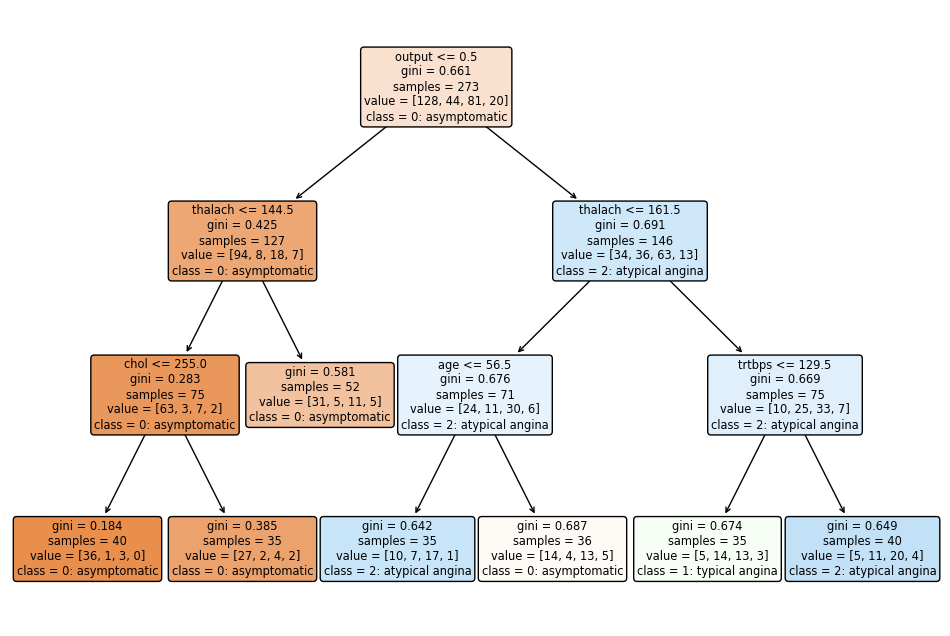

In [130]:
# Extract the decision tree model from the pipeline
decision_tree_model = best_dt_pipeline.named_steps['decision_tree']

# Convert feature names from pandas Index to list
feature_names_list = X.columns.tolist()

# Specify class names (if known) or set to None
# Example for binary classification: ["Class 0", "Class 1"]
# Replace with your actual class names or set class_names_list = None
class_names_list = ["0: asymptomatic", "1: typical angina", "2: atypical angina", "3: non-anginal pain"]

# Plot the decision tree
plt.figure(figsize=(12, 8))  # Set the size of the figure
plot_tree(decision_tree_model, 
          filled=True, 
          feature_names=feature_names_list,
          class_names=class_names_list,
          rounded=True)
plt.show()

The first split occurs for output less than or equal to 0.5. This is the predicted probability of being diagnosed with heart disease or not. The next splits then occcur at maximum heart rates achieved during excersize.

# LDA

In [131]:
# Create a pipeline with preprocessing and logistic regression
lda_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('LDA', LinearDiscriminantAnalysis())
    ]
)

#Fit on data
lda_pipeline_fitted = lda_pipeline.fit(X, y)

#Get AUC ROC score
lda_scores = cross_val_score(lda_pipeline_fitted, X, y, cv=5, scoring='accuracy')

lda_acc = lda_scores.mean()

print(f"LDA Accuracy: {lda_acc}")

LDA Accuracy: 0.5424242424242424


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [132]:
# Create new column
heart_data['cp_is_3'] = np.where(heart_data['cp'] == 3, 1, 0).astype(int)
heart_data['cp_is_3'] = heart_data['cp_is_3'].astype("category")

heart_data['cp_is_0'] = np.where(heart_data['cp'] == 0, 1, 0).astype(int)
heart_data['cp_is_0'] = heart_data['cp_is_0'].astype("category")

heart_data['cp_is_1'] = np.where(heart_data['cp'] == 1, 1, 0).astype(int)
heart_data['cp_is_1'] = heart_data['cp_is_1'].astype("category")

heart_data['cp_is_2'] = np.where(heart_data['cp'] == 2, 1, 0).astype(int)
heart_data['cp_is_2'] = heart_data['cp_is_2'].astype("category")

heart_data.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_0,cp_is_1,cp_is_2
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,0,0,1
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,1,0,0
4,57,1,0,140,192,1,148,1,0,1,0,0


In [133]:
from sklearn.metrics import f1_score, make_scorer

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=['category', 'object']))      
    ],
    remainder="passthrough"
)

In [134]:
# Select features and target
X = heart_data.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = heart_data['cp_is_3']

# Logistic regression pipeline
lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression(max_iter = 10000))
])

# Fit on training data
lr_pipeline_fitted = lr_pipeline.fit(X,y)

# Get F1 score
lr_scores = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='f1_macro')

lr_f1 = lr_scores.mean()

print(f"cp_is_3, Logistic Regression F1 Score: {lr_f1}")

cp_is_3, Logistic Regression F1 Score: 0.4799787225048261


In [135]:
#cp_is_2
# Select features and target
X = heart_data.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = heart_data['cp_is_2']

# Fit on training data
lr_pipeline_fitted = lr_pipeline.fit(X,y)

# Get F1 score
lr_scores = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='f1_macro')

lr_f1 = lr_scores.mean()

print(f"cp_is_2, Logistic Regression F1 Score: {lr_f1}")

cp_is_2, Logistic Regression F1 Score: 0.4349072441505822


In [136]:
#cp_is_1
# Select features and target
X = heart_data.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = heart_data['cp_is_1']

# Fit on training data
lr_pipeline_fitted = lr_pipeline.fit(X,y)

# Get F1 score
lr_scores = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='f1_macro')

lr_f1 = lr_scores.mean()

print(f"cp_is_1, Logistic Regression F1 Score: {lr_f1}")

cp_is_1, Logistic Regression F1 Score: 0.45284241077168935


In [137]:
#cp_is_0
# Select features and target
X = heart_data.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = heart_data['cp_is_0']

# Fit model
lr_pipeline_fitted = lr_pipeline.fit(X,y)

# Get F1 score
lr_scores = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='f1_macro')

lr_f1 = lr_scores.mean()

print(f"cp_is_0, Logistic Regression F1 Score: {lr_f1}")

cp_is_0, Logistic Regression F1 Score: 0.6615773215824161


The OvR approach was best at distinguishing categories 0.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [138]:
# Reduce to 0 and 1
zero_one_df = heart_data[heart_data['cp'].isin([0,1])]

In [139]:
# Select features and target
X = zero_one_df.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = zero_one_df['cp']

# fit model
lr_pipeline_fitted = lr_pipeline.fit(X, y)

#AUC
scores1 = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='roc_auc')
score1 = scores1.mean()

print(f"0 & 1, Logistic Regression ROC AUC: {score1}")

0 & 1, Logistic Regression ROC AUC: 0.8352735042735043


In [140]:
# Reduce to 0 and 2
zero_two_df = heart_data[heart_data['cp'].isin([0,2])]

In [141]:
# Select features and target
X = zero_two_df.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = zero_two_df['cp']

# fit model
lr_pipeline_fitted = lr_pipeline.fit(X, y)

#AUC
scores2 = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='roc_auc')
score2 = scores2.mean()

print(f"0 & 2, Logistic Regression ROC AUC: {score2}")

0 & 2, Logistic Regression ROC AUC: 0.7485916289592761


In [142]:
# Reduce to 0 and 3
zero_three_df = heart_data[heart_data['cp'].isin([0,3])]

In [143]:
# Select features and target
X = zero_three_df.drop(["cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3", "cp"], axis = 1)
y = zero_three_df['cp']

# fit model
lr_pipeline_fitted = lr_pipeline.fit(X, y)

#AUC
scores3 = cross_val_score(lr_pipeline_fitted, X, y, cv=5, scoring='roc_auc')
score3 = scores3.mean()

print(f"0 & 3, Logistic Regression ROC AUC: {score3}")

0 & 3, Logistic Regression ROC AUC: 0.7296153846153848


The best OvO approach was between 0 and 1.